In [242]:
import numpy as np
import matplotlib.pyplot as plt
import wfdb
from scipy.signal import find_peaks
from scipy import interpolate

In [243]:
def convert_freq(wave, freq_orig, freq_target):
    """
    Converts the sampling frequency of an ECG wave.

    Parameters:
    wave (array): The original ECG wave data (1D for single lead or 2D for multiple leads).
    freq_orig (float): The original sampling frequency of the ECG wave.
    freq_target (float): The target sampling frequency to convert to.

    Returns:
    array: The ECG wave resampled to the target frequency.
    """

    # Handle 1D wave (single lead)
    if wave.ndim == 1:
        # Create original time indices based on the length of the wave
        t_old = np.arange(0, len(wave))
        
        # Create new time indices based on the target frequency
        t_new = np.arange(0, len(wave), freq_orig / freq_target)
        
        # Interpolate the original wave to create a continuous function
        wave_conti = interpolate.interp1d(t_old, wave, fill_value="extrapolate")
        
        # Use the interpolated function to resample the wave at the new time indices
        wave_resampled = wave_conti(t_new)

    # Handle 2D wave (multiple leads)
    else:
        # Create original time indices based on the number of columns (time dimension) in the wave
        t_old = np.arange(0, wave.shape[1])
        
        # Create new time indices based on the target frequency
        t_new = np.arange(0, wave.shape[1], freq_orig / freq_target)
        
        # Interpolate and resample each row (lead) of the 2D wave separately
        wave_resampled = np.array([interpolate.interp1d(t_old, w, fill_value="extrapolate")(t_new) for w in wave])
    
    # Return the resampled wave
    return wave_resampled

In [244]:
def prominent_peak(wave, eps=0):
    """
    Calculates the peak and prominence of the most prominent peak in a multi-channel wave.

    Parameters:
    wave (array): A single multi-channel wave.
    eps (float): A small value to return when no prominent peak is found (default is 0).

    Returns:
    tuple: A tuple containing the index of the peak and its prominence.
    """

    # If wave is multi-channel, average along the channel axis
    wave = np.average(wave, axis=0) if wave.ndim != 1 else wave

    # Find all positive peaks and their prominences
    peaks_pos, dct_pos = find_peaks(wave, prominence=0)
    # Find all negative peaks and their prominences (by finding peaks in the inverted wave)
    peaks_neg, dct_neg = find_peaks(-wave, prominence=0)

    # Combine positive and negative peaks
    peaks = list(peaks_pos) + list(peaks_neg)
    # Combine prominences, taking care to invert the prominence of the negative peaks
    prominences = list(dct_pos['prominences']) + list(-dct_neg['prominences'])

    # If no prominent peak is found, return the index of the maximum value in wave and eps
    if not prominences:
        return np.argmax(wave), eps
    
    # Find the index of the peak with the largest absolute prominence
    peak_idx = np.argmax(np.abs(prominences))
    return peaks[peak_idx], prominences[peak_idx]

In [245]:
def extract_block_intervals(ecg_signal, on_off_QRS, on_off_T, on_off_P):
    """
    Extracts intervals between the QRS complex, T waves, and P waves of an ECG signal.
    
    Parameters:
    ecg_signal (array): The electrocardiogram signal data of shape (12,n)
    on_off_QRS, on_off_T, on_off_P (arrays of tuples): Each tuple contains the start and end indices of each complex/wave.
    
    Returns:
    tuple of lists: Three lists containing the segments of the ecg_signal between the qrs complex, t wave, and p wave.
    """

    # Initialize lists to hold the interval data between the complexes and waves.
    qrs_to_t_intervals = []
    t_to_p_intervals = []
    p_to_qrs_intervals = []

    # Determine the smallest length among the three input lists to ensure all intervals have corresponding start and end points.
    min_len = min(len(on_off_QRS), len(on_off_T), len(on_off_P))

    # Iterate over the range from 1 to the minimum length of the lists.
    # We start at 1 because we reference previous indices (i-1) in the loop.
    for i in range(1, min_len):
        qrs_end = on_off_QRS[i-1][1]

        t_start = on_off_T[i-1][0]
        t_end = on_off_T[i-1][1]

        p_start = on_off_P[i-1][0]
        p_end = on_off_P[i-1][1]

        qrs_next = on_off_QRS[i][0]

        # Check if the indices are sequentially correct, ensuring there are no overlaps or misalignments.
        if qrs_end < t_start and t_end < p_start and p_end < qrs_next:
            # Append the ECG segments between the complexes/waves to their respective lists.
            qrs_to_t_intervals.append(ecg_signal[:,qrs_end:t_start])
            t_to_p_intervals.append(ecg_signal[:,t_end:p_start])
            p_to_qrs_intervals.append(ecg_signal[:,p_end:qrs_next])
        
    return qrs_to_t_intervals, t_to_p_intervals, p_to_qrs_intervals

In [246]:
def concatenate_pieces(ecg_block, leads, on_off_QRS, on_off_T, on_off_P):

    """
    Simulates ECG signals for each lead by concatenating various ECG components and intervals with random modifications.

    Parameters:
    waves (dict of arrays): Dictionary containing waveforms for each lead.
    leads (list): List of lead names.
    on_off_QRS, on_off_T, on_off_P (arrays of tuples): Each tuple contains the start and end indices of each complex/wave.

    Returns:
    tuple: A dictionary of simulated ECG signals for each lead and a dictionary with annotations for the positions of QRS, T, and P components in the signal.
    """
    
    all_ecg_signals = {}
    all_annotations = {}
    
    lead_qrs_samples = []
    lead_t_samples = []
    lead_p_samples = []
    
    # Process each QRS complex interval
    for onoff in on_off_QRS:
        if onoff[1] < ecg_block.shape[1]:
            qrs_segment = ecg_block[:, onoff[0]:onoff[1]]
            lead_qrs_samples.append(qrs_segment)
    
    # Process each T wave interval
    for onoff in on_off_T:
        if onoff[1] < ecg_block.shape[1]:
            t_segment = ecg_block[:, onoff[0]:onoff[1]]
            lead_t_samples.append(t_segment)
    
    # Process each P wave interval
    for onoff in on_off_P:
        if onoff[1] < ecg_block.shape[1]:
            p_segment = ecg_block[:, onoff[0]:onoff[1]]
            lead_p_samples.append(p_segment)
    
    # Calculate intervals between QRS to T, T to P, and P to QRS
    qrs_to_t_intervals, t_to_p_intervals, p_to_qrs_intervals = extract_block_intervals(ecg_block, on_off_QRS, on_off_T, on_off_P)
    
    # Initialize base signal with random noise
    base = 0.01 * (np.random.rand(ecg_block.shape[0], 100) - 0.5)

    # Initialize dictionary to store annotations
    annotations = {"qrs": [], "t": [], "p": []}

    # Set initial position and time shift
    current_pos = base.shape[1]
    time_shift = np.random.randint(1000)
    
    # Build synthetic ECG signal until the base signal length is 7000 samples
    while base.shape[1] < 7000:
        # Loop over wave collections and their annotation types
        for wave_collection, ann_type in zip([lead_qrs_samples, qrs_to_t_intervals, lead_t_samples, t_to_p_intervals, lead_p_samples, p_to_qrs_intervals], 
                                             ["qrs", "qrs_to_t", "t", "t_to_p", "p", "p_to_qrs"]):
            # Randomly select and adjust a wave segment
            select = np.random.randint(0, len(wave_collection))
            wave = wave_collection[select]
            wave = convert_freq(wave, 500, 500 + np.random.randint(-200, 200))
            vertical_shift = base[:, -1].reshape(-1, 1) - wave[:, 0].reshape(-1, 1)
            wave += vertical_shift

            # Record annotations if applicable
            if ann_type in ["qrs", "t", "p"]:
                if current_pos-time_shift > 0 and current_pos-time_shift + wave.shape[1] < 5000:
                    annotations[ann_type].append((current_pos-time_shift, current_pos-time_shift + wave.shape[1]))
                    
            # Concatenate wave segment to the base signal
            base = np.concatenate((base, wave), axis=1)
            current_pos += wave.shape[1]
    
    # Extract 5000-sample segments for each lead
    for i, lead in enumerate(leads):
        all_ecg_signals[lead] = base[i, time_shift:time_shift + 5000]
        all_annotations[lead] = annotations
    
    # Return the synthetic ECG signals and their annotations
    return all_ecg_signals, all_annotations

In [247]:
def waves2block(waves):
    # Get the length of the waveforms using the length of a specific lead (e.g., 'i')
    n = len(waves['i'])
    
    # Concatenate all waveforms into a 2D array where each row represents a lead
    return np.concatenate([waves[lead].reshape((1, n)) for lead in leads], axis=0)

In [248]:
# List of ECG files to be processed

# Otto's path: "/mnt/33e4ec23-4d45-45c9-8a2e-400ec6670e3c/data/medical/heart/ludb/data/"

# List of ECG files to be processed (from the lobachevsky database)
filenames = [
    "/Users/john/Downloads/synth_ecg/lobachevsky_data/data/1",
    "/Users/john/Downloads/synth_ecg/lobachevsky_data/data/2",
    "/Users/john/Downloads/synth_ecg/lobachevsky_data/data/3"
]

In [249]:
leads = None  # will store the names of the ECG leads (channels).
waves = {}  # Dictionary to store concatenated waveforms for each lead.
total_samples = 0

# Lists to store start and end points of the QRS complexes, T waves, and P waves
on_off_QRS = [] 
on_off_T = []  
on_off_P = []  

# Loop over each filename in a list called 'filenames'
for filename in filenames:
    record = wfdb.rdrecord(filename)  # Read the ECG record file using wfdb.

    # Initialize leads and waves dictionary during the first iteration
    if leads is None:
        leads = record.__dict__['sig_name']  # Extract lead names
        for lead in leads:
            waves[lead] = []  # Initialize an empty list for each lead in waves dictionary.

    # Read annotations specific to this file with the extension 'i'
    annotation = wfdb.rdann(filename, extension='i')
    sample = annotation.__dict__['sample'] + total_samples  # Adjust sample indices for concatenation.
    symbol = annotation.__dict__['symbol']  # Read the annotation symbols (ex: 'N' for QRS).

    # Concatenate waveforms from each lead into the waves dictionary
    for lead in leads:
        idx_lead = leads.index(lead)  # Get the index of the current lead.
        wave_orig = record.__dict__['p_signal'][:, idx_lead]  # Extract waveform data for this lead.
        waves[lead] = np.concatenate((waves[lead], wave_orig))  # Concatenate waveform data.

    # Apply FFT-based high-pass filter to remove baseline drift from the waveforms
    for lead in leads:
        spec = np.fft.fft(waves[lead])
        N = 7  # This value can be adjusted based on the sampling rate and desired cutoff frequency
        spec[0:N] = 0.0
        spec[-(N-1):] = 0.0
        waves[lead] = np.real(np.fft.ifft(spec))  # Replace the original signal with the denoised signal

    # Process each symbol and adjust on/off points for the respective waves
    for i in range(len(symbol)):
        if symbol[i] == 'N':
            on_off_QRS.append(np.array([sample[i-1], sample[i+1]]))  # Store QRS on-off points.
        elif symbol[i] == 't':
            on_off_T.append(np.array([sample[i-1], sample[i+1]]))  # Store T wave on-off points.
        elif symbol[i] == 'p':
            on_off_P.append(np.array([sample[i-1], sample[i+1]]))  # Store P wave on-off points.

    # Update total sample count for next file's index adjustment
    total_samples += record.__dict__['p_signal'].shape[0]  # Add the number of samples in this record.


In [250]:
# Convert lists of on-off points for QRS, T, and P waves into NumPy arrays
on_off_QRS = np.asarray(on_off_QRS)
on_off_T = np.asarray(on_off_T)
on_off_P = np.asarray(on_off_P)

# Calculate RR intervals, which are the times between successive QRS complexes.
rr_intervals = np.diff(on_off_QRS[:, 0])  # Compute differences between successive QRS start points.
rr_mean = np.mean(rr_intervals)  # Calculate the mean of the RR intervals.
rr_std = np.std(rr_intervals)  # Calculate the standard deviation of the RR intervals.

# Calculate QT intervals, which are the times from the start of the QRS complex to the start of the T wave.
qt_ints = [t[0] - qrs[0] for qrs, t in zip(on_off_QRS, on_off_T)]  # List comprehension to compute QT intervals.
qt_int_mean = np.mean(qt_ints)  
qt_int_std = np.std(qt_ints) 

In [251]:
# Convert the waveforms to a block format
waves_block = waves2block(waves)

In [252]:
# Generate synthetic ECG signals for each lead using the block format
all_ecg_signals, all_annotations = concatenate_pieces(waves_block, leads, on_off_QRS, on_off_T, on_off_P)

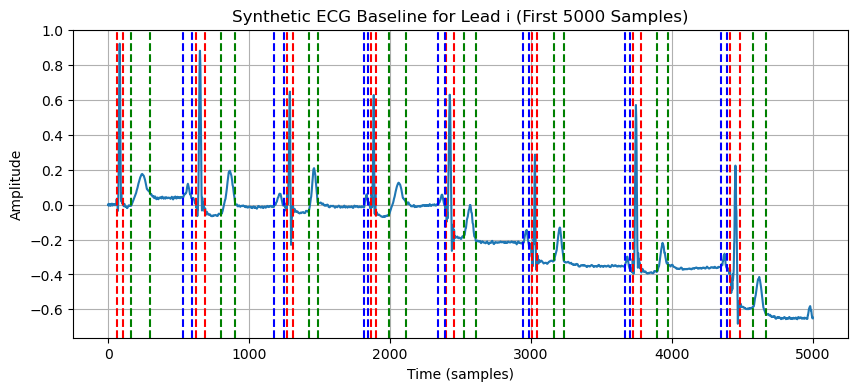

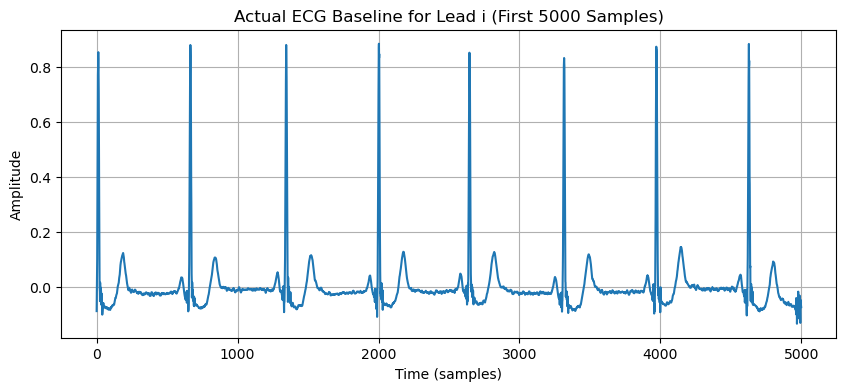

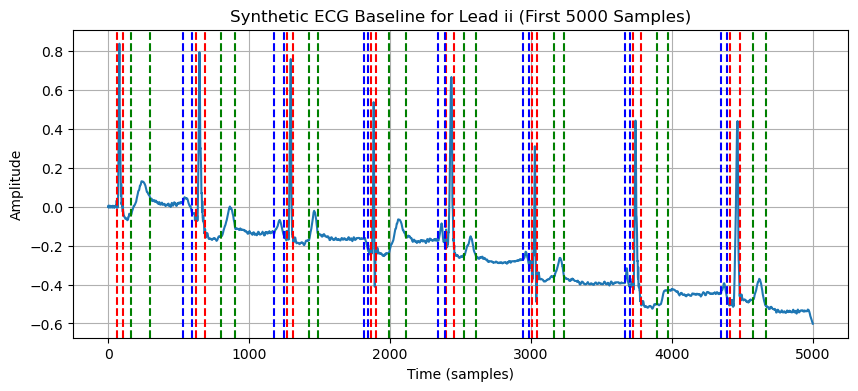

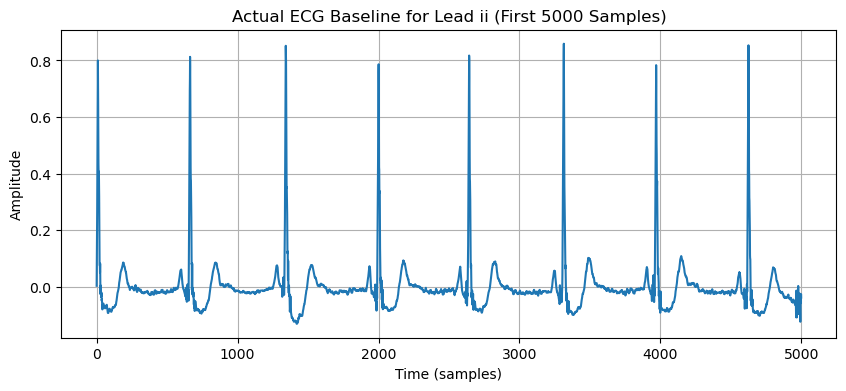

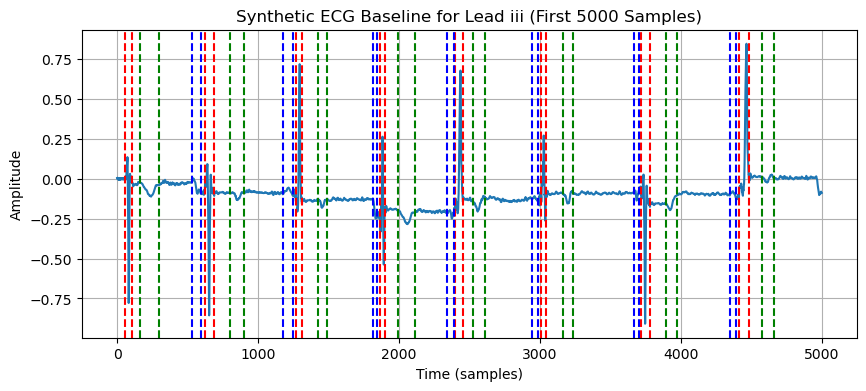

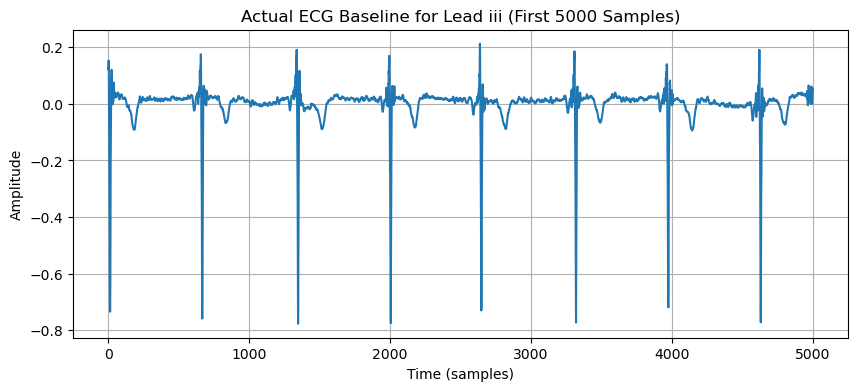

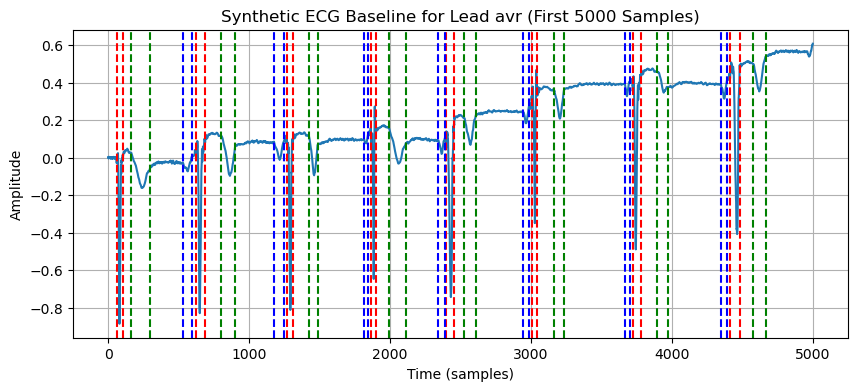

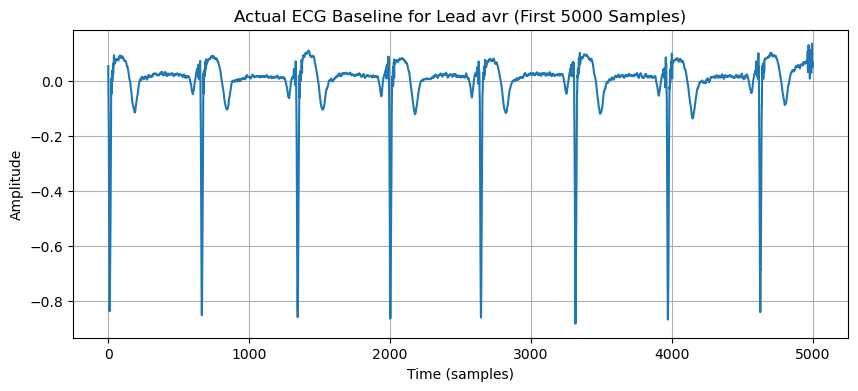

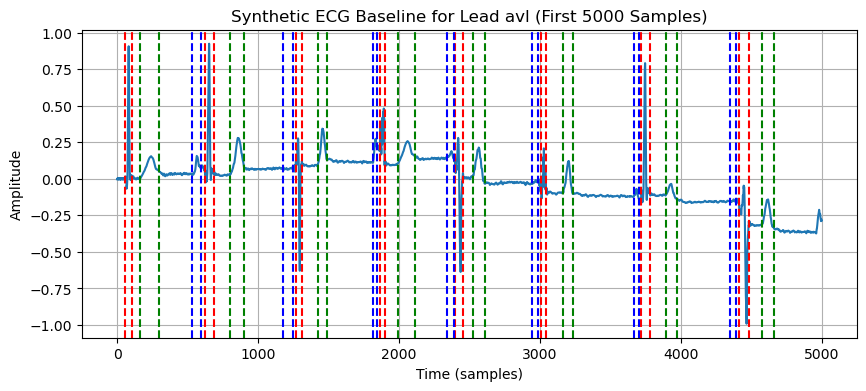

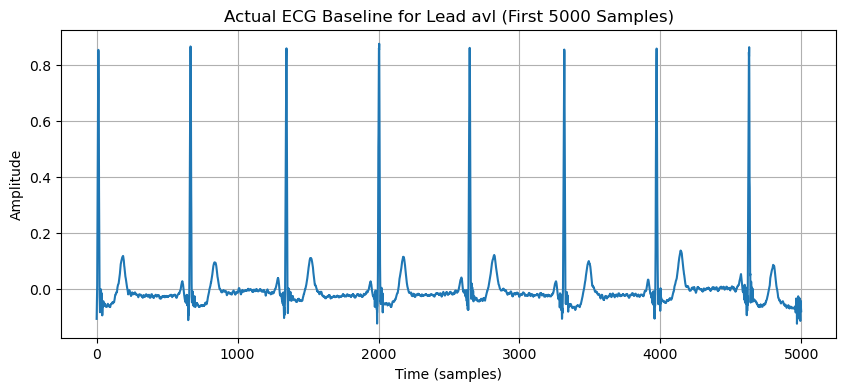

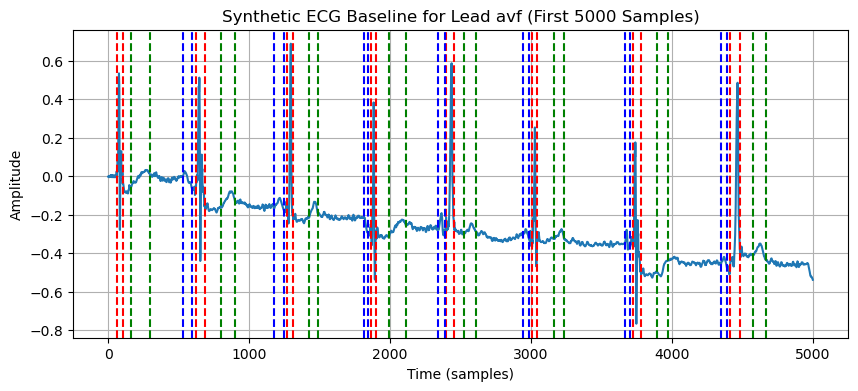

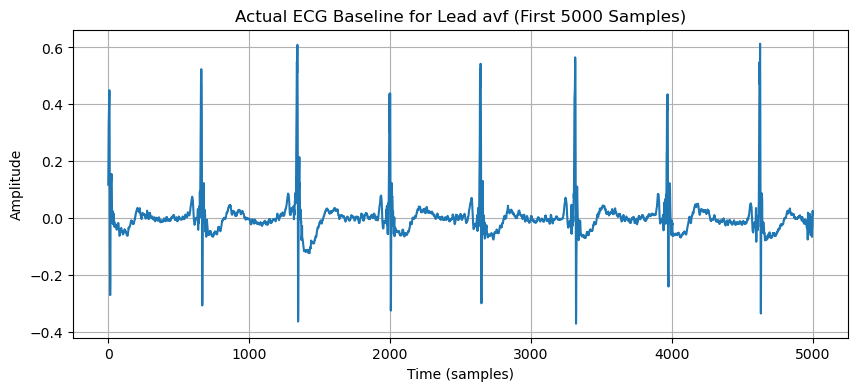

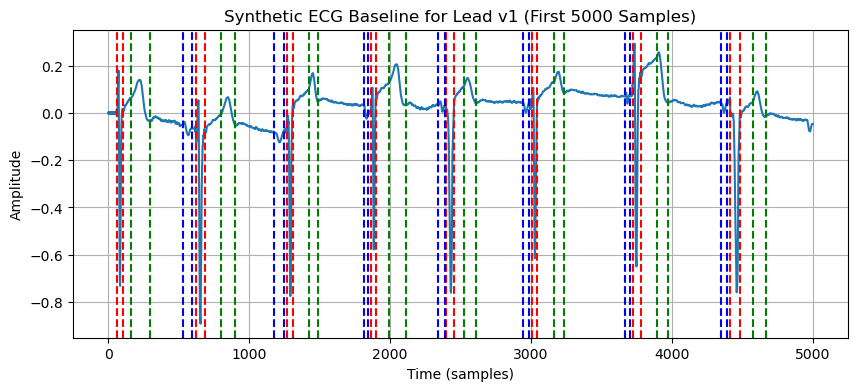

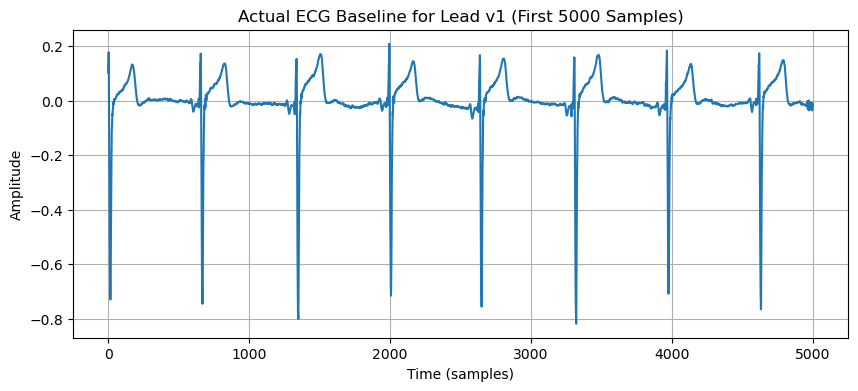

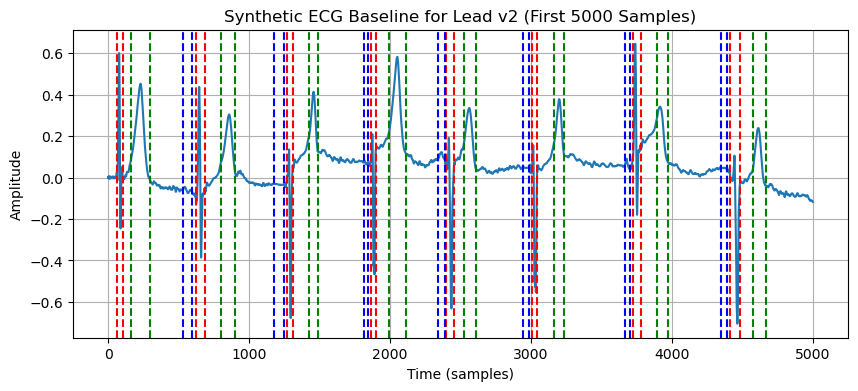

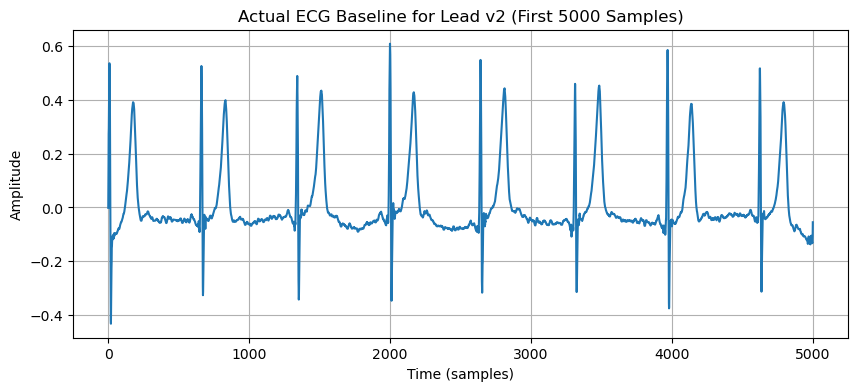

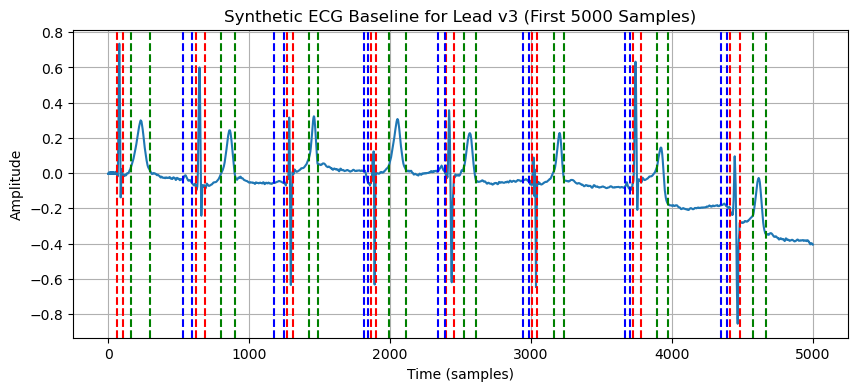

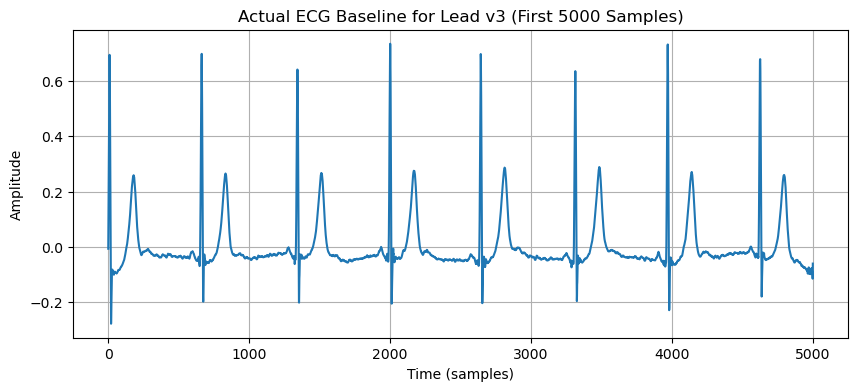

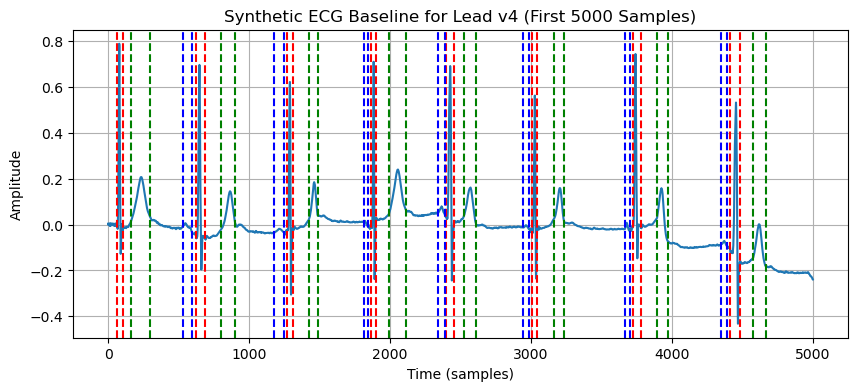

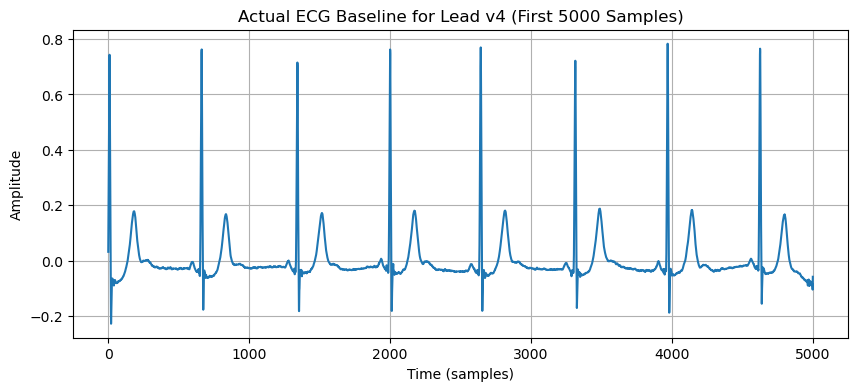

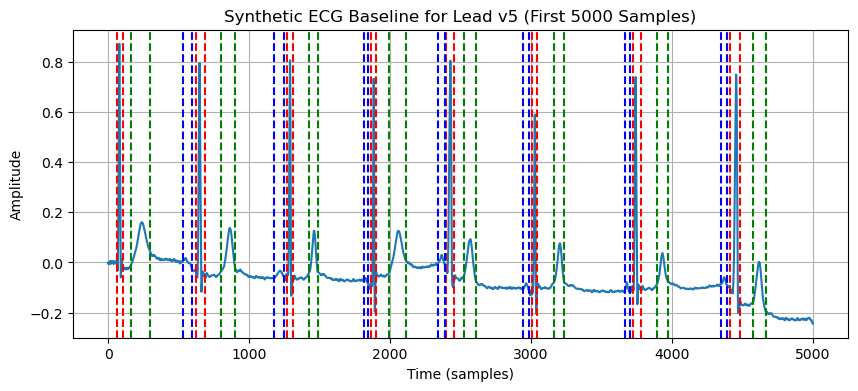

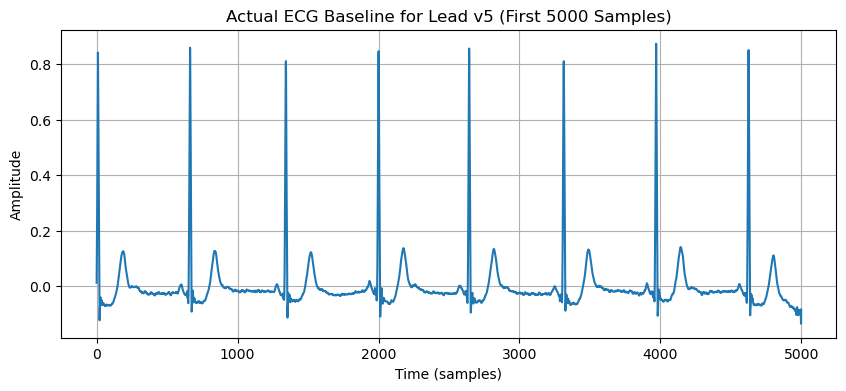

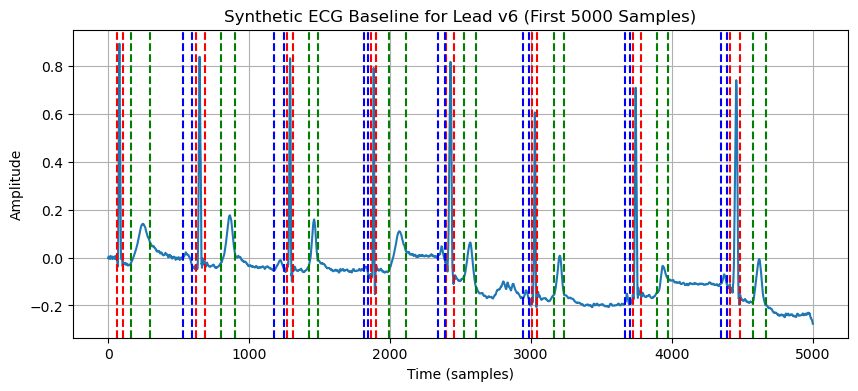

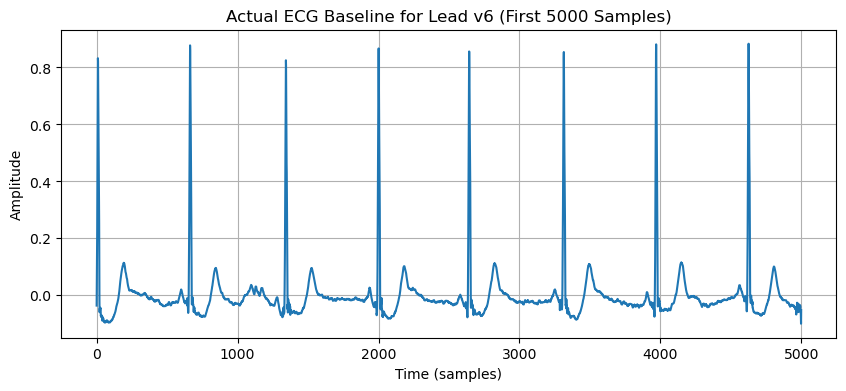

In [253]:
# Plot and save the results
for lead in leads:
    # Generate a synthetic ECG for the current lead using the concatenate_pieces function.
    # This function takes the QRS, T, and P wave samples along with their intervals.
    r_ecg = all_ecg_signals[lead]
    annotations = all_annotations[lead]

    # Plotting the synthetic ECG waveform for the current lead.
    plt.figure(figsize=(10, 4))
    plt.plot(r_ecg[0:5000])  # Plot only the first 5000 samples.
    plt.title(f'Synthetic ECG Baseline for Lead {lead} (First 5000 Samples)')
    plt.xlabel('Time (samples)')
    plt.ylabel('Amplitude')
    plt.grid(True)

    # Annotate the plot with information from 'annotations', which contains start and end points for QRS, T, and P waves.
    for ann_type, ann_list in annotations.items():
        color = {'qrs': 'r', 't': 'g', 'p': 'b'}[ann_type]  # Set colors for different annotations (red for qrs, green for t waves, blue for p waves)
        for (start, end) in ann_list:
            plt.axvline(x=start, color=color, linestyle='--')  # Mark the start of the wave.
            plt.axvline(x=end, color=color, linestyle='--')    # Mark the end of the wave.
    plt.show()

    # Plotting the actual ECG baseline waveform for comparison.
    plt.figure(figsize=(10, 4))
    plt.plot(waves[lead][0:5000])  # Plot only the first 5000 samples of the actual waveform.
    plt.title(f'Actual ECG Baseline for Lead {lead} (First 5000 Samples)')
    plt.xlabel('Time (samples)')
    plt.ylabel('Amplitude')
    plt.grid(True)
    plt.show()